# Use XGBoost classifier on Titanic data

In [12]:
#import the work titanic data into adata frame 
import pandas as pd
base_train_df = pd.read_csv('/Users/jonathan/Desktop/titanic_data/TitanicTrain.csv')

In [13]:
base_train_df.head()

,PassengerId,Survived,Pclass,Name,Female,Age,SibSp,Parch,Ticket,Fare,Cabin,EmQ,EmS,EmC
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,1,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1,0


In [14]:
train_df = base_train_df[['Survived', 'Pclass','Female', 'Age', 'SibSp', 'Parch', 'EmQ', 'EmS', 'EmC']]
train_df.head()


,Survived,Pclass,Female,Age,SibSp,Parch,EmQ,EmS,EmC
0,0,3,0,22.0,1,0,0,1,0
1,1,1,1,38.0,1,0,0,0,1
2,1,3,1,26.0,0,0,0,1,0
3,1,1,1,35.0,1,0,0,1,0
4,0,3,0,35.0,0,0,0,1,0


In [15]:
X, y = train_df.loc[:, train_df.columns != 'Survived'], train_df['Survived']


In [16]:
from sklearn.model_selection import train_test_split
# split data into train and test sets
seed = 7
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)


In [17]:
#import necessary libraries
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier(learning_rate = 0.05,
 n_estimators=300,
 max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [18]:
# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [19]:
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.11%


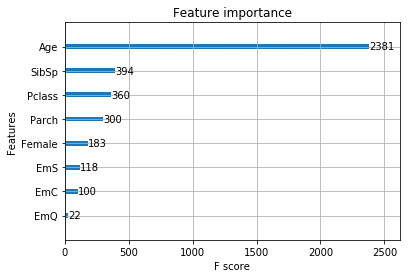

In [20]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# plot feature importance
plot_importance(model)
plt.show()

In [30]:
#Adapted from https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.006, n=8, Accuracy: 83.33%
Thresh=0.026, n=7, Accuracy: 83.33%
Thresh=0.031, n=6, Accuracy: 84.44%
Thresh=0.047, n=5, Accuracy: 81.11%
Thresh=0.078, n=4, Accuracy: 74.44%
Thresh=0.093, n=3, Accuracy: 74.44%
Thresh=0.102, n=2, Accuracy: 68.89%
Thresh=0.617, n=1, Accuracy: 65.56%


In [22]:
#Import test set to use for validation and export ot Kaggle
base_test_df = pd.read_csv('/Users/jonathan/Desktop/titanic_data/test.csv')
X_test_file = base_test_df[['Pclass','Female', 'Age', 'SibSp', 'Parch','EmQ', 'EmS', 'EmC']]
X_test_file.head()


,Pclass,Female,Age,SibSp,Parch,EmQ,EmS,EmC
0,3,0,34.5,0,0,1,0,0
1,3,1,47.0,1,0,0,1,0
2,2,0,62.0,0,0,1,0,0
3,3,0,27.0,0,0,0,1,0
4,3,1,22.0,1,1,0,1,0


In [23]:
# make predictions for test data
y_pred_file = model.predict(X_test_file)
predictions_file = [round(value) for value in y_pred_file]

#create a df of predictions for test data
pred_df_file = pd.DataFrame({'Survived':predictions_file})

#combine the passenger id and their associated prediciton
output = pd.concat([base_test_df['PassengerId'],pred_df_file],axis=1, sort=False)

#output a file that can be submitted to Kaggle
path='/Users/jonathan/Desktop/titanic_data/'
output.to_csv(path+'final_titanic', encoding='utf-8', index=False)

# Show feature importance

In [25]:
import xgboost as xgb

#Create a DMatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [26]:
params = {"objective":'binary:logistic','colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

In [27]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[22:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

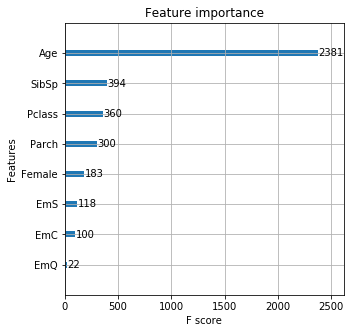

In [29]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [ 5, 5]